## 0 - Model training

#### last class wrap up functions

In [10]:
#basics
import pandas as pd
import numpy as np
#processing
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics._regression import _check_reg_targets

#models
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [30]:
def prepare_data(data):
    data = data.dropna()
    data = data.query("year != 2020")
    data = data.sort_values(by='release_date')
    data.release_date = pd.to_datetime(data.release_date)
    data.index = data.release_date
    y = data.sales
    y = y.astype(float)
    X = data.drop(columns=['index', 'year', 'sales', 'release_date'], errors='ignore')
    return X,y

def train_test_split_by_date(df: pd.DataFrame, split_date: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date[
    - test: [split_date:]
    """
    train = df.loc[:split_date].copy()
    test = df.loc[split_date:].copy()
    return train, test

def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def get_evaluation_metrics(y_test, y_pred, y_train=None) -> dict:
    metrics = {
        'mape': mean_absolute_percentage_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred, squared=True),
        'rmse': mean_squared_error(y_test, y_pred, squared=False),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
    }
    return metrics

def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100


def prettify_metrics(metrics: dict) -> str:
    output = [f"Evaluation:\n{'-'*10}"]
    for name, metric in metrics.items():
        output.append((f'- {name.upper()}: {round(metric, 2)}'))
    return '\n'.join(output)

def train_test_learner(learners):
    for lr in learners:
        print(lr.__class__)
        lr = lr.fit(X_train, y_train)
        yhat = lr.predict(X_test)
        print(prettify_metrics(get_evaluation_metrics(y_test, yhat)))
        print('\n')

#### Prepare data

In [48]:
data_processed = pd.read_csv('/Users/yaguethiam/Ponts/data_prepared_ponts_v4.csv')

In [49]:
X, y = prepare_data(data_processed)

X_train, X_test = train_test_split_by_date(X, '2018-01-01')
y_train, y_test = train_test_split_by_date(y, '2018-01-01')

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#todo

#### Models Evaluation

In [31]:
learners = [LinearRegression(),RandomForestRegressor(), LGBMRegressor()]
train_test_learner(learners)

<class 'sklearn.linear_model._base.LinearRegression'>
Evaluation:
----------
- MAPE: 1185.43
- MSE: 51183156852.65
- RMSE: 226236.95
- MAE: 129010.34
- R2: 0.56


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Evaluation:
----------
- MAPE: 1251.39
- MSE: 52114654061.29
- RMSE: 228286.34
- MAE: 124703.72
- R2: 0.55


<class 'lightgbm.sklearn.LGBMRegressor'>
Evaluation:
----------
- MAPE: 986.91
- MSE: 47208306381.14
- RMSE: 217274.73
- MAE: 115518.99
- R2: 0.59




### 1 - Choice of metrics/Loss

- which metrics is more adequate in predicting the target?
- Do we care if the prediction is slightly higher than the ground truth?
- Do we care if it is lower?
- Do we want to predict lower values as much as higher values?
--> plot metrics per quartile

#### Metrics per quartile 

In [50]:
quantiles = [data_processed['sales'].quantile(0.25), data_processed['sales'].quantile(0.5), data_processed['sales'].quantile(0.75), data_processed['sales'].quantile(1.)]

In [51]:
lr = LGBMRegressor().fit(X_train, y_train)

In [64]:
quantiles

[23970.0, 73797.0, 205136.75, 4378720.0]

In [59]:
X_test_i = X_test.copy()
y_test_i = y_test.copy()
X_test_i['sales'] = y_test_i
X_test_i = X_test_i[X_test_i['sales']<=quantiles[0]]
print(X_test_i.shape)
y_test_i = X_test_i['sales'].astype(float)
X_test_i.drop('sales', axis =1, inplace = True)
yhat = lr.predict(X_test_i)
print(prettify_metrics(get_evaluation_metrics(y_test_i, yhat)))

(217, 56)
Evaluation:
----------
- MAPE: 3130.56
- MSE: 7592562276.54
- RMSE: 87135.31
- MAE: 68440.72
- R2: -159.2


In [60]:
X_test_i = X_test.copy()
y_test_i = y_test.copy()
X_test_i['sales'] = y_test_i
X_test_i = X_test_i[(X_test_i['sales']>quantiles[0]) & (X_test_i['sales']<=quantiles[1])]
print(X_test_i.shape)
y_test_i = X_test_i['sales'].astype(float)
X_test_i.drop('sales', axis =1, inplace = True)
yhat = lr.predict(X_test_i)
print(prettify_metrics(get_evaluation_metrics(y_test_i, yhat)))

(185, 56)
Evaluation:
----------
- MAPE: 156.77
- MSE: 9599426710.19
- RMSE: 97976.66
- MAE: 62853.15
- R2: -45.5


In [61]:
X_test_i = X_test.copy()
y_test_i = y_test.copy()
X_test_i['sales'] = y_test_i
X_test_i = X_test_i[(X_test_i['sales']>quantiles[1]) & (X_test_i['sales']<=quantiles[2])]
print(X_test_i.shape)
y_test_i = X_test_i['sales'].astype(float)
X_test_i.drop('sales', axis =1, inplace = True)
yhat = lr.predict(X_test_i)
print(prettify_metrics(get_evaluation_metrics(y_test_i, yhat)))

(167, 56)
Evaluation:
----------
- MAPE: 60.72
- MSE: 14152267108.14
- RMSE: 118963.3
- MAE: 71999.72
- R2: -9.42


In [62]:
X_test_i = X_test.copy()
y_test_i = y_test.copy()
X_test_i['sales'] = y_test_i
X_test_i = X_test_i[(X_test_i['sales']>quantiles[2])]
print(X_test_i.shape)
y_test_i = X_test_i['sales'].astype(float)
X_test_i.drop('sales', axis =1, inplace = True)
yhat = lr.predict(X_test_i)
print(prettify_metrics(get_evaluation_metrics(y_test_i, yhat)))

(168, 56)
Evaluation:
----------
- MAPE: 52.85
- MSE: 172652459764.56
- RMSE: 415514.69
- MAE: 277583.76
- R2: 0.39


### 2 - Model training and Selection (quick and dirty)

In [14]:
data_processed.shape

(6676, 59)

In [37]:
data_processed['sales'].quantile(0.5)

73797.0

In [36]:
data_processed['sales'].median()

73797.0

In [15]:
print(f"mean: {data_processed['sales'].mean().round(2)}")
print(f"max: {data_processed['sales'].max().round(2)}")
print(f"min: {data_processed['sales'].min().round(2)}")
print(f"min: {data_processed['sales'].std().round(2)}")

mean: 192758.3
max: 4378720
min: 35
min: 345442.64


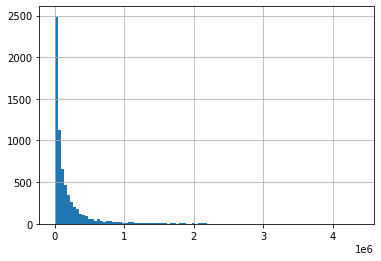

In [19]:
data_processed['sales'].hist(bins=100)

- see where we can make improvments

- see if the data category has an impact

- see distribution of the target

- can we improve the target to predict?

Answer: lognormal distributuion , meaning the log value of the sales follow a normal distribution

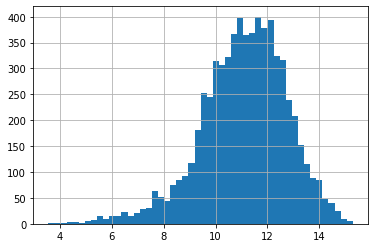

In [22]:
data_processed['sales'].apply(lambda x: np.log(x)).hist(bins=50)

In [65]:
X, y = prepare_data(data_processed)

X_train, X_test = train_test_split_by_date(X, '2018-01-01')
y_train, y_test = train_test_split_by_date(y, '2018-01-01')

In [73]:
def prettify_metrics(metrics: dict) -> str:
    output = [f"Evaluation:\n{'-'*10}"]
    for name, metric in metrics.items():
        output.append((f'- {name.upper()}: {round(metric, 2)}'))
    return '\n'.join(output)

def train_test_learner(learners):
    for lr in learners:
        print(lr.__class__)
        lr = lr.fit(X_train, y_train.apply(lambda x: np.log(x)))
        yhat = lr.predict(X_test)
        print(prettify_metrics(get_evaluation_metrics(y_test, [np.exp(x) for x in yhat])))
        print('\n')

In [74]:
learners = [LinearRegression(),RandomForestRegressor(), LGBMRegressor()]
train_test_learner(learners)

<class 'sklearn.linear_model._base.LinearRegression'>
Evaluation:
----------
- MAPE: 469.75
- MSE: 2128429412830.11
- RMSE: 1458913.78
- MAE: 191188.52
- R2: -17.3


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Evaluation:
----------
- MAPE: 442.6
- MSE: 56544436834.83
- RMSE: 237790.74
- MAE: 105840.68
- R2: 0.51


<class 'lightgbm.sklearn.LGBMRegressor'>
Evaluation:
----------
- MAPE: 402.64
- MSE: 61469125204.82
- RMSE: 247929.68
- MAE: 107553.21
- R2: 0.47




### 3 - Cross validation 

- Why? 
- get the generalization error of your model

#### 3.1.1 Train/Validation

- the most used,, quick and dirty but not recommended

- Why? when you not doing model selection

####  3.1.2 - Train/Validation/Test

- reccommended. 
- Why?

#### 3.2 K-Fold, etc other type of validation

When do you use it? --> small dataset

- KFold

Not always a good choice specially for time series

#### 3.3 Compare the model validation methods

### 4 - Regularization

- Mostly used to avoid overfitting. Penelize models with lots of parameters

### 5 - Hyperparameters Optimization

- how to choose the parameter of the parameters of your model?